In [31]:
from ultralytics import YOLO
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageFile
import ultralytics.engine.results as results
import PIL
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_gt(path,ax):
    data=np.loadtxt(path.replace("images", "labels").replace("jpg","txt")).T
    # print(data)
    cls = data[0]
    bboxes = data[1:].T
    z = data[-1]
    # print(bboxes)
    img = PIL.Image.open(path)
    ax.imshow(np.array(img))
    ax.axis("off")
    for bbox,z_value in zip(bboxes,z):
        x,y,w,h = bbox*512
        rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="blue", facecolor='none')
        ax.text(*rect.get_xy(),f"z={z_value:.3f}")
        ax.add_patch(rect)

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")
# print(model.model.model)
print("loaded")
test_images = os.listdir("data_gen/Dataset/images/test")
random_image = lambda: "data_gen/Dataset/images/test/"+test_images[np.random.randint(0,len(test_images))]



loaded


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>


image 1/1 /home/jupyter-till/git/ultralytics/data_gen/Dataset/images/test/image_00101.jpg: 512x512 10 beads, 2.8ms
Speed: 0.5ms preprocess, 2.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)


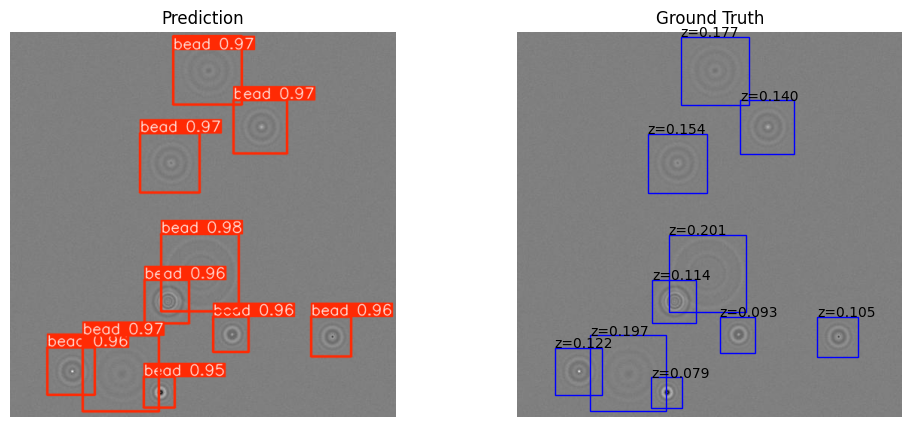

In [37]:
plt.figure(figsize=(12,5))
image = random_image()
results = model.predict(image)
res = results[0].plot()
plt.subplot(1,2,1)
plt.title("Prediction")
plt.imshow(res)
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Ground Truth")

plot_gt(image,plt.gca())
plt.show()

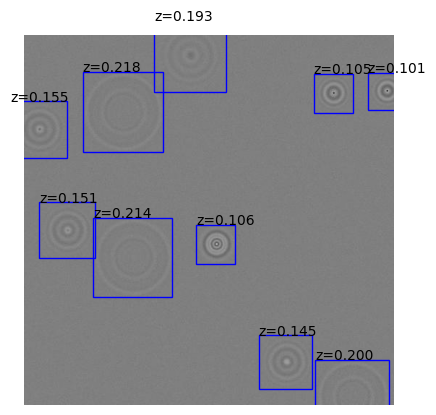

In [26]:
plot_gt(image)

In [1]:
import PIL.Image
import PIL.ImageFile
import ultralytics.engine.results as results
import PIL
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.clf()
data=np.loadtxt("/home/till/git/ultralytics/data_gen/Dataset/labels/test/image_00400.txt").T
# print(data)
cls = data[0]
bboxes = data[1:-1].T
z = data[-1]
# print(bboxes)
img = PIL.Image.open("/home/till/git/ultralytics/data_gen/Dataset/images/test/image_00400.jpg")
plt.imshow(np.array(img))
plt.axis("off")
for bbox,z_value in zip(bboxes,z):
    x,y,w,h = bbox*512
    rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="blue", facecolor='none')
    plt.text(*rect.get_xy(),f"z={z_value:.3f}")
    plt.gca().add_patch(rect)

NameError: name 'np' is not defined

<Figure size 640x480 with 0 Axes>

In [40]:
np.concatenate((bboxes.squeeze().T,np.column_stack((np.zeros(20),np.ones(20),cls))),axis=1)

array([[    0.39407,      0.4882,     0.20526,     0.20526,           0,           1,           0],
       [    0.76743,     0.48312,     0.20957,     0.20957,           0,           1,           0],
       [    0.91439,    0.093389,     0.19378,     0.19378,           0,           1,           0],
       [    0.90239,     0.78923,    0.059248,    0.059248,           0,           1,           0],
       [     0.6538,     0.35354,     0.13533,     0.13533,           0,           1,           0],
       [    0.17428,     0.93156,     0.15297,     0.15297,           0,           1,           0],
       [    0.57298,     0.77022,     0.17327,     0.17327,           0,           1,           0],
       [     0.8609,     0.97222,     0.15092,     0.15092,           0,           1,           0],
       [    0.37873,      0.2368,    0.054531,    0.054531,           0,           1,           0],
       [     0.5115,     0.96207,     0.16486,     0.16486,           0,           1,           0],


In [39]:
bboxes.squeeze().shape

(4, 20)

In [38]:
np.column_stack((np.zeros(20),np.ones(20),cls)).shape

(20, 3)